In [2]:
import torch

CONTENT_FILE = './input/input_boy.wav'
STYLE_FILE = './input/input_girl.wav'

learning_rate = 0.001

content_weight = 1.0
style_weight = 1.0

print_period = 100
max_epochs = 20000

# If gpu is available
if torch.cuda.is_available():  
    device = torch.device('cuda')
else:
    device = torch.device('cpu')



# Reading

In [3]:
from utils import *
import torch

N_FFT = 512


x_content, sr = loadFile(CONTENT_FILE)
x_style, sr = loadFile(STYLE_FILE)

a_content = wav2spectrum(x_content, N_FFT)
a_style = wav2spectrum(x_style, N_FFT)

print(x_content.shape, a_content.shape)
print(x_style.shape, a_style.shape)
print(sr)

plot_spectrogram_with_raw_signal(x_content, sr, 'content spectrum')
plot_spectrogram_with_raw_signal(x_style, sr, 'style spectrum')


c:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


FileNotFoundError: [Errno 2] No such file or directory: './input/input_boy.wav'

# Training

In [3]:
import torch.optim as optim
from models import *


model = RandomCNN()
model.eval()



a_C = torch.tensor(a_content[None, None, :, :], requires_grad = False, device = device).float()
a_S = torch.tensor(a_style[None, None, :, :], requires_grad = False, device = device).float()


# optimizer
a_G_var = torch.randn(a_C.shape, device = device) * 0.001
a_G_var.requires_grad = True

optimizer = optim.Adam(
    params = [a_G_var],
    lr = learning_rate,
)

model.to(device)

a_C = model(a_C)
a_S = model(a_S)


losses = []
style_losses = []
content_losses = []

for epoch in range(1, max_epochs + 1):

    optimizer.zero_grad()
    a_G = model(a_G_var)
    
    content_loss = content_weight * RandomCNN.compute_content_loss(a_C, a_G)
    style_loss = style_weight * RandomCNN.compute_layer_style_loss(a_S, a_G)

    loss = content_loss + style_loss
    loss.backward()
    optimizer.step()

    if epoch % print_period == 0:
        print('{}/{} content_loss: {:4f}, style_loss: {:4f}, total_loss: {:4f}'.format(
            epoch,
            max_epochs,
            content_loss,
            style_loss,
            loss
        ))

    losses.append(loss.detach().cpu())
    content_losses.append(content_loss.detach().cpu())
    style_losses.append(style_loss.detach().cpu())

gen_spectrum = a_G_var.cpu().data.numpy().squeeze()


100/20000 content_loss: 0.028311, style_loss: 510.909698, total_loss: 510.938019
200/20000 content_loss: 0.025346, style_loss: 436.375671, total_loss: 436.401031
300/20000 content_loss: 0.024172, style_loss: 352.910400, total_loss: 352.934570
400/20000 content_loss: 0.023939, style_loss: 275.749298, total_loss: 275.773224
500/20000 content_loss: 0.024151, style_loss: 212.298752, total_loss: 212.322906
600/20000 content_loss: 0.024500, style_loss: 162.212265, total_loss: 162.236771
700/20000 content_loss: 0.024900, style_loss: 123.273209, total_loss: 123.298111
800/20000 content_loss: 0.025282, style_loss: 93.699081, total_loss: 93.724365
900/20000 content_loss: 0.025645, style_loss: 71.674240, total_loss: 71.699883
1000/20000 content_loss: 0.025976, style_loss: 55.529247, total_loss: 55.555222
1100/20000 content_loss: 0.026320, style_loss: 43.684776, total_loss: 43.711098
1200/20000 content_loss: 0.026707, style_loss: 35.040787, total_loss: 35.067493
1300/20000 content_loss: 0.027093, 

# plot loss curve

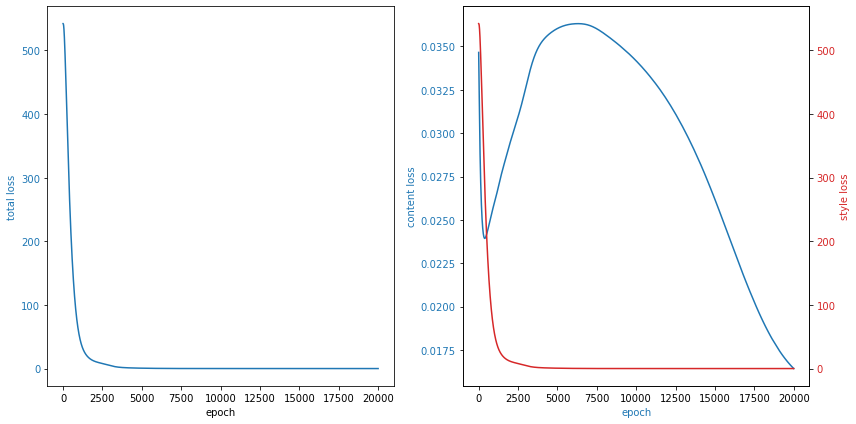

In [4]:
import utils

utils.plot_curve(content_losses, style_losses, losses, same_y_scale=False)

# Save file

In [ ]:
import os

filename = 'randomCNN.wav'

x = spectrum2wav(gen_spectrum, N_FFT)
writeFile(os.path.join('./output/', filename), x, sr)


# 